Импортируем необходимые библиотеки

In [647]:
import pandas as pd
import tqdm
import time
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

Создадим сущность вебрайвера и передадим в него ссылку на наш сайт.

In [277]:
from selenium.webdriver.chrome.options import Options
options = Options() # создаем сущность Options
options.add_argument("start-maximized") # открываем на полный экран
wb = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options) 
wb.get("https://vestinn.ru/") # открываем ссылку
time.sleep(3)

Переходим с помощью кликера на страницу новостной выдачи.

In [278]:
# Кликаем на поисковик
search = wb.find_element(By.XPATH, '//*[@id="layoutMain"]/header/div[1]/div/form/div[2]/input') # ищем элемент
search.click()
time.sleep(3)

In [279]:
# Вписываем в поиск "Никитин"
element = wb.find_element(By.XPATH, '//*[@id="layoutMain"]/header/div[1]/div/form/div[2]/input')
element.send_keys("Никитин")
time.sleep(5)
element.send_keys(Keys.RETURN)

In [280]:
# Сорок раз нажимаем на кнопку для прогрузки новых новостей
for i in range(40):
    time.sleep(1)
    button_click = wb.find_element(By.XPATH, '//*[@id="layoutMain"]/div[2]/div/main/div[1]/button')
    button_click.click()
    time.sleep(1)

Собираем ссылки на новости.

In [281]:
html = wb.page_source
soup = BeautifulSoup(html)
links = ['https://vestinn.ru' + i.get('href') for i in soup.find_all('a', {'class': 'searchResult__link'})]

In [282]:
len(links)

205

In [283]:
links

['https://vestinn.ru/news/society/230959/',
 'https://vestinn.ru/news/vesti/230908/',
 'https://vestinn.ru/news/incident/230869/',
 'https://vestinn.ru/news/vesti/230862/',
 'https://vestinn.ru/news/vesti/230851/',
 'https://vestinn.ru/news/vesti/230843/',
 'https://vestinn.ru/news/vesti/230845/',
 'https://vestinn.ru/news/science/230840/',
 'https://vestinn.ru/news/incident/230839/',
 'https://vestinn.ru/news/vesti/230819/',
 'https://vestinn.ru/news/society/230825/',
 'https://vestinn.ru/news/politics/230822/',
 'https://vestinn.ru/news/incident/230799/',
 'https://vestinn.ru/news/vesti/230794/',
 'https://vestinn.ru/news/vesti/230796/',
 'https://vestinn.ru/news/society/230789/',
 'https://vestinn.ru/news/vesti/230773/',
 'https://vestinn.ru/news/vesti/230787/',
 'https://vestinn.ru/news/vesti/230708/',
 'https://vestinn.ru/news/vesti/230703/',
 'https://vestinn.ru/news/society/230642/',
 'https://vestinn.ru/news/society/230641/',
 'https://vestinn.ru/news/economy/230622/',
 'https:

In [284]:
wb.close()
time.sleep(3)

In [650]:
def parser(link):
    '''
    Данная функция c помощью Selenium принимает на вход ссылку на страницу новости, 
    затем достает из нее необхомую нам информацию c помощью BeautifulSoup:
    заголовок, дату, время, категорию новости, количество просмотров, количество комментариев, автора статьи.
    После чего, формирует pandas-датафрейм из полученных данных со страницы.
    Код в ячейке ниже данной функцией проходится по всем ссылкам на новости и включает их в датафрейм.
    '''
    wb = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options) 
    wb.get(link) # открываем ссылку
    time.sleep(3)
    html = wb.page_source # сохраним html страницы с помощью .page_source
    soup = BeautifulSoup(html) # сварим суп
    # Заголовок
    title = soup.find_all('h1', {'class': 'news__title'})[0].text
    # Дата
    date = soup.find_all('div', {'class':'news__date'})[0].text
    # Время
    times = soup.find_all('div', {'class':'news__time'})[0].text
    # Категория
    category = soup.find_all('div', {'class': 'tags_list'})[0].text.strip()
    # Количество просмотров
    views = int(soup.find_all('div', {'class':'news__views'})[0].text)
    # Количество комментариев
    comments = int(soup.find_all('div', {'class':'news__post'})[0].text)
    # Автор статьи
    try:
        author_name = soup.find_all('a', {'class':'news__author-name'})[0].text
    except:
        author_name = None
    

    # Заносим переменные в pandas DataFrame
    df = pd.DataFrame({'Заголовок': [title],
                       'Дата': [date],
                        'Время': [times],
                         'Категория': [category],
                         'Количество просмотров': [views],
                        'Количество комментариев': [comments],
                        'Автор статьи': [author_name],
                        'Ссылка': [link]})
    return df

In [651]:
help(parser)

Help on function parser in module __main__:

parser(link)
    Данная функция c помощью Selenium принимает на вход ссылку на страницу новости,
    затем достает из нее необхомую нам информацию c помощью BeautifulSoup:
    заголовок, дату, время, категорию новости, количество просмотров, количество комментариев, автора статьи.
    После чего, формирует pandas-датафрейм из полученных данных со страницы.
    Код в ячейке ниже данной функцией проходится по всем ссылкам на новости и включает их в датафрейм.



In [294]:
news = pd.DataFrame()
problem_links = []

for link in tqdm.tqdm(links):
    try:
        one_news_data = parser(link)
        news = pd.concat([news, one_news_data])
    except: 
        problem_links.append(link)
        print("Не удалось собрать!")

100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [50:06<00:00, 14.66s/it]


In [295]:
news

,Заголовок,Дата,Время,Категория,Количество просмотров,Количество комментариев,Автор статьи,Ссылка
0,Более 580 млн рублей направят дополнительно в ...,15.03.24,15:30,#Общество,491,0,None,https://vestinn.ru/news/society/230959/
0,В Арзамасе Благовещенская церковь обретает гол...,14.03.24,19:07,#Вести,578,0,Ирина Водина,https://vestinn.ru/news/vesti/230908/
0,СМИ: СБУ взяла на себя ответственность за атак...,13.03.24,14:55,#Происшествия,922,0,None,https://vestinn.ru/news/incident/230869/
0,"Глеб Никитин: ""В 2024 году мы должны принять р...",13.03.24,14:03,#Вести,704,0,Елена Гомонова,https://vestinn.ru/news/vesti/230862/
0,"""Вести-Приволжье"" - главные новости региона. В...",13.03.24,11:33,#Вести,495,0,Юлия Кузнецова,https://vestinn.ru/news/vesti/230851/
...,...,...,...,...,...,...,...,...
0,Глеб Никитин вступил в должность губернатора Н...,26.09.23,14:20,#Политика,5401,0,None,https://vestinn.ru/news/politics/223913/
0,Церемония вступления Глеба Никитина в должност...,26.09.23,11:00,#Общество,1418,0,None,https://vestinn.ru/news/society/223894/
0,"""Вести-Приволжье.Утро"". Новости начала дня 26 ...",26.09.23,10:33,#Вести,591,0,None,https://vestinn.ru/news/vesti/223922/
0,Ключи от 16 спецавтомобилей нижегородским пожа...,25.09.23,23:30,#Вести,252,0,None,https://vestinn.ru/news/vesti/223980/


Сохраним получившийся датафрейм

In [296]:
news.to_excel('Итоговый датафрейм по новостям.xlsx')

### Анализ данных

Загрузим получившийся датафрейм, чтобы спокойно в нем работать.

In [652]:
df = pd.read_excel('Итоговый датафрейм по новостям.xlsx')

In [653]:
del df['Unnamed: 0']

In [654]:
df

,Заголовок,Дата,Время,Категория,Количество просмотров,Количество комментариев,Автор статьи,Ссылка
0,Более 580 млн рублей направят дополнительно в ...,15.03.24,15:30,#Общество,491,0,NaN,https://vestinn.ru/news/society/230959/
1,В Арзамасе Благовещенская церковь обретает гол...,14.03.24,19:07,#Вести,578,0,Ирина Водина,https://vestinn.ru/news/vesti/230908/
2,СМИ: СБУ взяла на себя ответственность за атак...,13.03.24,14:55,#Происшествия,922,0,NaN,https://vestinn.ru/news/incident/230869/
3,"Глеб Никитин: ""В 2024 году мы должны принять р...",13.03.24,14:03,#Вести,704,0,Елена Гомонова,https://vestinn.ru/news/vesti/230862/
4,"""Вести-Приволжье"" - главные новости региона. В...",13.03.24,11:33,#Вести,495,0,Юлия Кузнецова,https://vestinn.ru/news/vesti/230851/
...,...,...,...,...,...,...,...,...
200,Глеб Никитин вступил в должность губернатора Н...,26.09.23,14:20,#Политика,5401,0,NaN,https://vestinn.ru/news/politics/223913/
201,Церемония вступления Глеба Никитина в должност...,26.09.23,11:00,#Общество,1418,0,NaN,https://vestinn.ru/news/society/223894/
202,"""Вести-Приволжье.Утро"". Новости начала дня 26 ...",26.09.23,10:33,#Вести,591,0,NaN,https://vestinn.ru/news/vesti/223922/
203,Ключи от 16 спецавтомобилей нижегородским пожа...,25.09.23,23:30,#Вести,252,0,NaN,https://vestinn.ru/news/vesti/223980/


In [655]:
df['Дата'] = df['Дата'].str.split('.').apply(lambda x: f"{x[1]}.{x[0]}.{x[2]}")

In [656]:
df

,Заголовок,Дата,Время,Категория,Количество просмотров,Количество комментариев,Автор статьи,Ссылка
0,Более 580 млн рублей направят дополнительно в ...,03.15.24,15:30,#Общество,491,0,NaN,https://vestinn.ru/news/society/230959/
1,В Арзамасе Благовещенская церковь обретает гол...,03.14.24,19:07,#Вести,578,0,Ирина Водина,https://vestinn.ru/news/vesti/230908/
2,СМИ: СБУ взяла на себя ответственность за атак...,03.13.24,14:55,#Происшествия,922,0,NaN,https://vestinn.ru/news/incident/230869/
3,"Глеб Никитин: ""В 2024 году мы должны принять р...",03.13.24,14:03,#Вести,704,0,Елена Гомонова,https://vestinn.ru/news/vesti/230862/
4,"""Вести-Приволжье"" - главные новости региона. В...",03.13.24,11:33,#Вести,495,0,Юлия Кузнецова,https://vestinn.ru/news/vesti/230851/
...,...,...,...,...,...,...,...,...
200,Глеб Никитин вступил в должность губернатора Н...,09.26.23,14:20,#Политика,5401,0,NaN,https://vestinn.ru/news/politics/223913/
201,Церемония вступления Глеба Никитина в должност...,09.26.23,11:00,#Общество,1418,0,NaN,https://vestinn.ru/news/society/223894/
202,"""Вести-Приволжье.Утро"". Новости начала дня 26 ...",09.26.23,10:33,#Вести,591,0,NaN,https://vestinn.ru/news/vesti/223922/
203,Ключи от 16 спецавтомобилей нижегородским пожа...,09.25.23,23:30,#Вести,252,0,NaN,https://vestinn.ru/news/vesti/223980/


In [657]:
df['Дата'] = df['Дата'].apply(pd.to_datetime)
df['Время'] = pd.to_datetime(df['Время'], format = '%H:%M')

In [658]:
df['Дата_и_время'] = df['Дата'] + pd.to_timedelta(df['Время'].dt.strftime('%H:%M:%S'))

In [659]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Заголовок                205 non-null    object        
 1   Дата                     205 non-null    datetime64[ns]
 2   Время                    205 non-null    datetime64[ns]
 3   Категория                205 non-null    object        
 4   Количество просмотров    205 non-null    int64         
 5   Количество комментариев  205 non-null    int64         
 6   Автор статьи             31 non-null     object        
 7   Ссылка                   205 non-null    object        
 8   Дата_и_время             205 non-null    datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 14.5+ KB


Удалим колонку Время из-за ненадобности

In [660]:
del df['Время']

Сделаем еще одну numeric колонку, потому что по требованиям к проекту их должно быть минимум 3. В нашем случае, мы взяли репортажи, если категория включает в себя слово 'Вести', то это является частью программы выпуска новостей. Этому значению присваивается 1, в противном случае, если новость не входила в программу выпуска новостей, то присваивается 0.

In [661]:
df['Вести'] = df['Категория'].apply(lambda x: 1 if '#Вести' in x else 0)

Также в качестве numeric переменной можно сделать автора статьи, где 1 будет присваиваться, если есть автор статьи, а 0 - если он не указан.

In [662]:
df['Есть автор?'] = df['Автор статьи'].notna().astype(int)

Также сделаем еще одну numeric переменную, которая будет показывать, есть ли упоминание губернатора в заголовке статьи.

In [663]:
df['Заголовок'] = df['Заголовок'].str.lower()

In [664]:
df['Губернатор_упоминание'] = df['Заголовок'].apply(lambda x: 1 if 'губернатор' in x or 'никитин' in x else 0)

In [665]:
df

,Заголовок,Дата,Категория,Количество просмотров,Количество комментариев,Автор статьи,Ссылка,Дата_и_время,Вести,Есть автор?,Губернатор_упоминание
0,более 580 млн рублей направят дополнительно в ...,2024-03-15,#Общество,491,0,NaN,https://vestinn.ru/news/society/230959/,2024-03-15 15:30:00,0,0,0
1,в арзамасе благовещенская церковь обретает гол...,2024-03-14,#Вести,578,0,Ирина Водина,https://vestinn.ru/news/vesti/230908/,2024-03-14 19:07:00,1,1,0
2,сми: сбу взяла на себя ответственность за атак...,2024-03-13,#Происшествия,922,0,NaN,https://vestinn.ru/news/incident/230869/,2024-03-13 14:55:00,0,0,0
3,"глеб никитин: ""в 2024 году мы должны принять р...",2024-03-13,#Вести,704,0,Елена Гомонова,https://vestinn.ru/news/vesti/230862/,2024-03-13 14:03:00,1,1,1
4,"""вести-приволжье"" - главные новости региона. в...",2024-03-13,#Вести,495,0,Юлия Кузнецова,https://vestinn.ru/news/vesti/230851/,2024-03-13 11:33:00,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
200,глеб никитин вступил в должность губернатора н...,2023-09-26,#Политика,5401,0,NaN,https://vestinn.ru/news/politics/223913/,2023-09-26 14:20:00,0,0,1
201,церемония вступления глеба никитина в должност...,2023-09-26,#Общество,1418,0,NaN,https://vestinn.ru/news/society/223894/,2023-09-26 11:00:00,0,0,1
202,"""вести-приволжье.утро"". новости начала дня 26 ...",2023-09-26,#Вести,591,0,NaN,https://vestinn.ru/news/vesti/223922/,2023-09-26 10:33:00,1,0,0
203,ключи от 16 спецавтомобилей нижегородским пожа...,2023-09-25,#Вести,252,0,NaN,https://vestinn.ru/news/vesti/223980/,2023-09-25 23:30:00,1,0,0


Посмотрим на описательные статистики переменной "Количество комментариев", как можно заметить, она везде равна нулю, то есть комментарии под всеми собранными новостями отсутствуют.

In [666]:
df['Количество комментариев'].describe()

count    205.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: Количество комментариев, dtype: float64

Построим график распределения переменной Вести в виде круговой диаграммы.

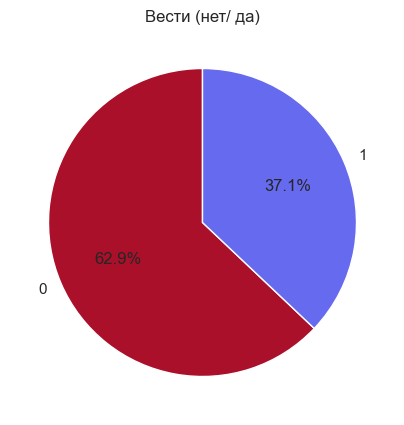

In [667]:
vesti_count = df['Вести'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(vesti_count, labels=vesti_count.index, autopct='%1.1f%%', colors=["#AB102A", "#666AEE"], startangle=90)
plt.title("Вести (нет/ да)", fontsize=12);

37% всех публикаций в датафрейме являются телерепортажами, остальные 63% являются просто новостными статьями на сайте.

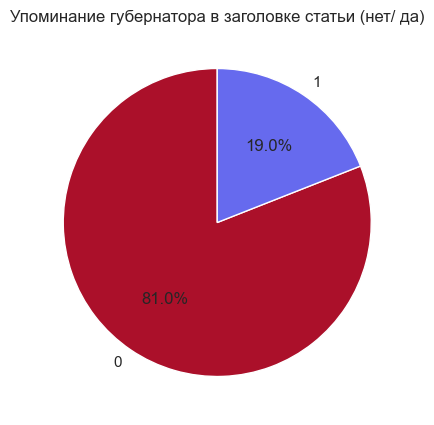

In [668]:
governor_count = df['Губернатор_упоминание'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(governor_count, labels=governor_count.index, autopct='%1.1f%%', colors=["#AB102A", "#666AEE"], startangle=90)
plt.title("Упоминание губернатора в заголовке статьи (нет/ да)", fontsize=12);

В 19% заголовков есть упоминание губернатора.

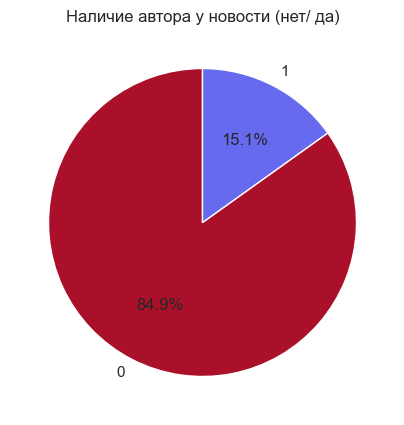

In [669]:
author_count = df['Есть автор?'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(author_count, labels=author_count.index, autopct='%1.1f%%', colors=["#AB102A", "#666AEE"], startangle=90)
plt.title("Наличие автора у новости (нет/ да)", fontsize=12);

В 15.1% случаев у новостей есть автор.

Теперь посмотрим на среднее количество просмотров под статьей в зависимости от наличия упоминания губернатора.

In [670]:
views_by_gov = df[['Губернатор_упоминание', 'Количество просмотров']]

In [671]:
avg_views_by_gov = views_by_gov.groupby('Губернатор_упоминание', as_index = False).agg({'Количество просмотров':'mean'})\
                                                            .sort_values('Количество просмотров', ascending = False)\
                                                            .rename(columns = {'Количество просмотров':'Среднее количество просмотров'})

In [672]:
avg_views_by_gov

,Губернатор_упоминание,Среднее количество просмотров
1,1,1836.410256
0,0,1698.897590


In [673]:
import scipy.stats as ss
ss.ttest_ind(views_by_gov['Губернатор_упоминание'], views_by_gov['Количество просмотров'])

TtestResult(statistic=-17.437324231532617, pvalue=2.760367929466257e-51, df=408.0)

Среднее количество просмотров в новости, если упоминается губернатор, больше, чем в новостях, где нет этого упоминания. Данный результат является статистически значимым, если верить t-test'у.

Теперь посмотрим на среднее количество просмотров под статьей в зависимости от категории.

In [674]:
avg_views_by_cat = df.groupby('Категория', as_index = False).agg({'Количество просмотров':'mean'})\
                                                            .sort_values('Количество просмотров', ascending = False)\
                                                            .rename(columns = {'Количество просмотров':'Среднее количество просмотров'})

In [675]:
avg_views_by_cat

,Категория,Среднее количество просмотров
12,#Политика,5022.000000
14,#Политика\n#Экономика и бизнес,4879.000000
3,#Медицина и экология,4809.000000
2,#Культура,4748.500000
10,#Общество\n#Политика,4536.000000
1,#Вести\n#Политика,4484.000000
9,#Общество\n#Наука и образование,4409.000000
18,#Экономика и бизнес,3778.727273
5,#Наука и образование,3656.200000
17,#Спорт\n#Общество,3469.000000


C:\Users\aksen\AppData\Local\Temp\ipykernel_27048\2544675995.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_views_by_cat,


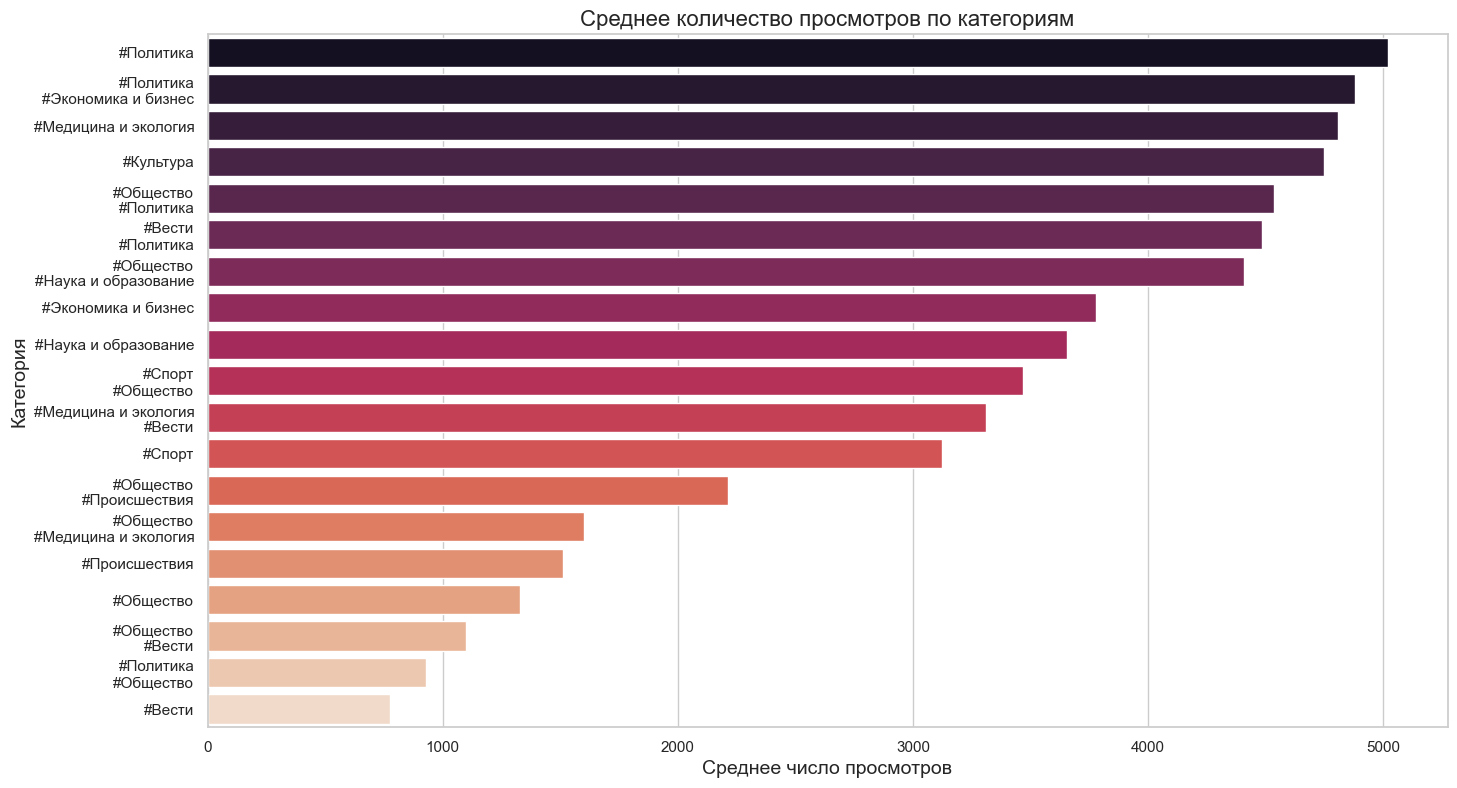

In [676]:
plt.figure(figsize=(16, 9))
sns.barplot(data=avg_views_by_cat,
            x='Среднее количество просмотров', y='Категория', palette='rocket')
plt.xlabel('Среднее число просмотров', fontsize=14)
plt.ylabel('Категория', fontsize=14)
plt.title('Среднее количество просмотров по категориям', fontsize=16);

Наиболее популярной категорией новостных статей, исходя из количества просмотров, является политика, а на втором месте политика, экономика и бизнес, а на третьем медицина и экология. При этом, наименее популярной является категория Вести, несмотря на большое количество самих новостей с этим тегом.

In [677]:
df.groupby('Категория').agg({'Количество просмотров':'mean', 'Категория':'count'})\
                        .sort_values('Количество просмотров', ascending = False)\
                        .rename(columns = {'Категория':'Количество новостей'}).reset_index()

,Категория,Количество просмотров,Количество новостей
0,#Политика,5022.000000,10
1,#Политика\n#Экономика и бизнес,4879.000000,1
2,#Медицина и экология,4809.000000,3
3,#Культура,4748.500000,2
4,#Общество\n#Политика,4536.000000,1
5,#Вести\n#Политика,4484.000000,1
6,#Общество\n#Наука и образование,4409.000000,1
7,#Экономика и бизнес,3778.727273,11
8,#Наука и образование,3656.200000,5
9,#Спорт\n#Общество,3469.000000,1


Как можно заметить из таблицы выше, такие популярные по количеству новостей категории, как Общество и Вести имеют довольно мало просмотров в среднем, что говорит людям больше интересны сферы политики, экономики, медицины и культуры. По крайней мере, если смотреть на новости, в которых упоминается губернатор региона.

Теперь посмотрим на наиболее и наименее популярные новости в зависимости от количества просмотров.

In [680]:
df[['Заголовок', 'Категория', 'Количество просмотров', 'Губернатор_упоминание']].sort_values('Количество просмотров', ascending = False)

,Заголовок,Категория,Количество просмотров,Губернатор_упоминание
188,в правительстве нижегородской области переназн...,#Политика,6938,1
200,глеб никитин вступил в должность губернатора н...,#Политика,5401,1
137,минздрав нижегородской области предложил запре...,#Медицина и экология,5309,0
173,министром образования нижегородской области ст...,#Политика,5233,0
182,еще три министра переназначены в правительстве...,#Политика,5123,0
...,...,...,...,...
6,"""вести-приволжье"" - главные новости региона. в...",#Вести,445,0
16,"нацпроект: ""демография""",#Вести,389,0
190,какую рыбу можно есть беременным и кормящим ма...,#Вести,354,0
203,ключи от 16 спецавтомобилей нижегородским пожа...,#Вести,252,0


Как можно заметить, наибольшее число просмотров собирают новости в сфере политики, а наименьшее в категории Вести. При этом, прямое упоминание в заголовке статей, есть только у первых двух новостей, в остальных новостях такая информация в заголовке отсутствует, хотя сам губернатор в новости упоминается.

Посмотрим на количество просмотров по дням.

In [619]:
avg_views_by_day = df.groupby('Дата', as_index = False).agg({'Количество просмотров': 'mean'})

In [620]:
avg_views_by_day.sort_values('Количество просмотров', ascending = False)

,Дата,Количество просмотров
16,2023-10-26,4913.0
35,2023-11-22,4879.0
21,2023-11-02,4793.0
52,2023-12-12,4587.0
69,2024-01-20,4484.0
...,...,...
40,2023-11-27,648.0
102,2024-03-14,578.0
24,2023-11-07,555.0
103,2024-03-15,491.0


Больше всего просмотров новостей пришлось на 26 октября, а меньше всего на 26 января.

Теперь построим линейный график просмотров по дням, однако, стоит применить слользящее среднее, чтобы сгладить информацию на графике, взяв окно в 10 дней, и сделать его более наглядным.

In [621]:
avg_views_by_day['Количество просмотров'] = avg_views_by_day['Количество просмотров'].rolling(10).mean().round(2)

In [622]:
avg_views_by_day

,Дата,Количество просмотров
0,2023-09-25,NaN
1,2023-09-26,NaN
2,2023-09-27,NaN
3,2023-09-28,NaN
4,2023-09-29,NaN
...,...,...
99,2024-03-08,996.42
100,2024-03-12,1018.51
101,2024-03-13,967.96
102,2024-03-14,936.31


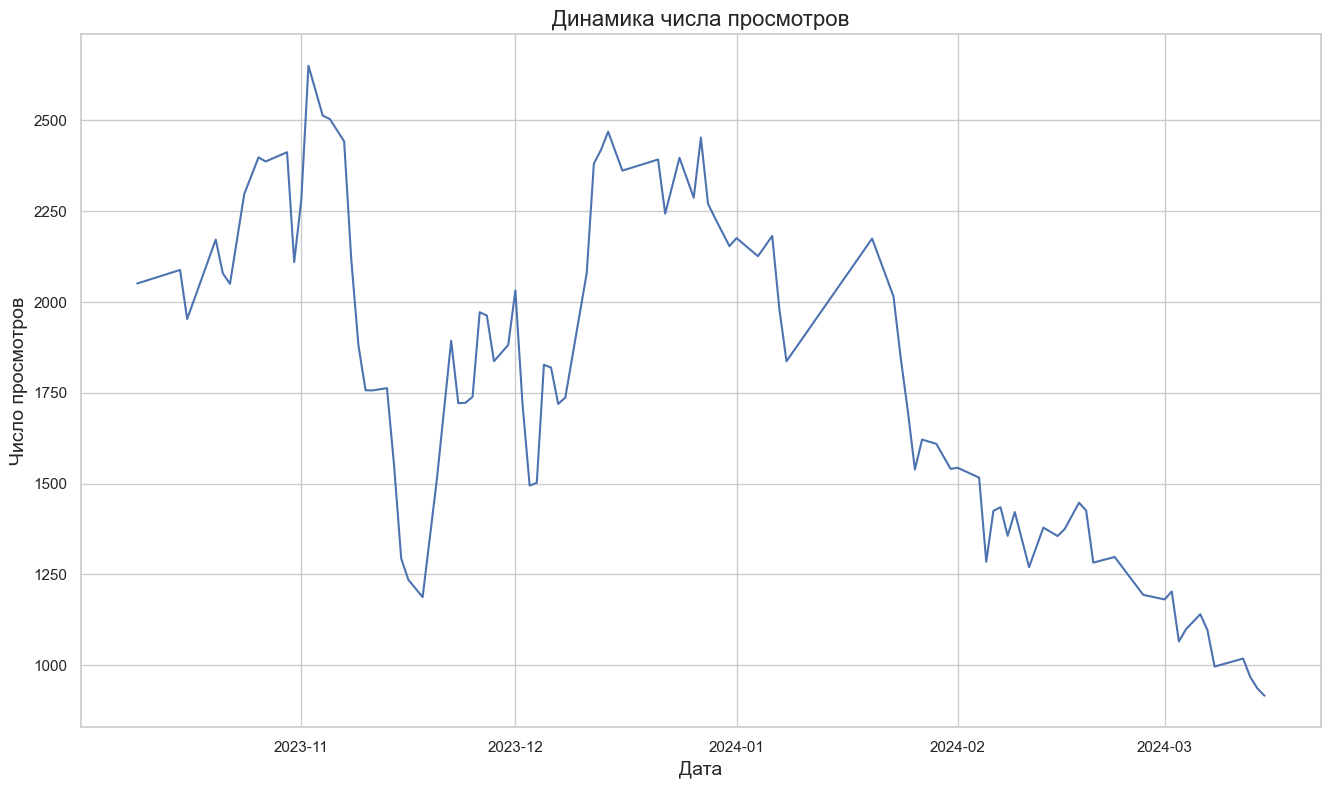

In [624]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=avg_views_by_day,
            x='Дата', y='Количество просмотров')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число просмотров', fontsize=14)
plt.title('Динамика числа просмотров', fontsize=16);

Данный график показывает общий тренд количества просмотров новостей с упоминанием губернатора Нижегородской области, и видно, что с начала 2024 года, среднее количество просмотров шло на спад, а пик по просмотрам пришелся на начало ноября 2023. Хотя, понятно, что чем новость ближе к настоящему, тем на ней будет меньше просмотров, при прочих равных условиях, ибо та или иная новость могла не успеть собрать нужное количество просмотров.

Посмотрим на распределение числа просмотров в виде ящика с усами.

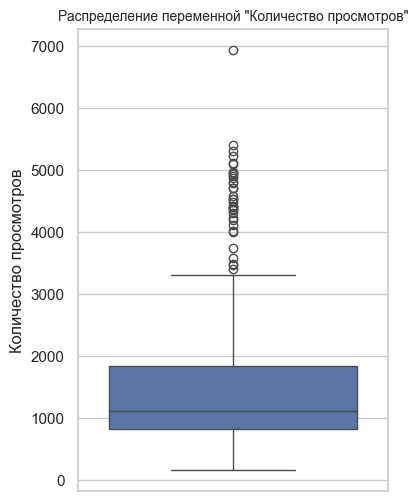

In [625]:
plt.figure(figsize=(4, 6))
sns.boxplot(data = df['Количество просмотров'])
plt.title('Распределение переменной "Количество просмотров"', fontsize=10);

In [626]:
# Описательные статистики по числу просмотров
df['Количество просмотров'].describe()

count     205.000000
mean     1725.058537
std      1416.292677
min       165.000000
25%       828.000000
50%      1112.000000
75%      1850.000000
max      6938.000000
Name: Количество просмотров, dtype: float64

Как можно заметить, среднее число просмотров в нашем датафрейме равно 1725, а медиана 1112, это говорит о том, что распределение скошено вправо, то есть большее число наблюдений имеют просмотры меньше среднего. Нижний квартиль равен 828, что означает, что 25% новостей имеют меньше 828 просмотров, а остальные 75% новостей - больше просмотров. Верхний квартиль 1850, это значит, что у 75% новостей просмотры меньше 1850, а у оставшихся 25% - больше. Максимальное число просмотров равно 6938, а минимальное - 165. Размах (разница между наибольшим и наименьшим значением) в переменной является довольно большим, при этом также, если верить ящику с усами, имеется довольно много выбросов в данных, но выбросы находятся только с одной стороны графика, с большей стороны.

In [627]:
author_counts = df['Автор статьи'].value_counts()

In [628]:
author_counts

Автор статьи
Константин Крестников     7
Ирина Водина              6
Елена Гомонова            4
Александр Фирстов         2
Татьяна  Локтева          2
Елена Лядова              2
Татьяна Колпакова         2
Юлия Кузнецова            1
Евгений Мельников         1
Олеся Локовщук            1
Марина Гальцынова         1
Марина Ревягина           1
Евгений Карпов            1
Name: count, dtype: int64

C:\Users\aksen\AppData\Local\Temp\ipykernel_27048\1179090369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = author_counts.values, y=author_counts.index, palette='rocket')


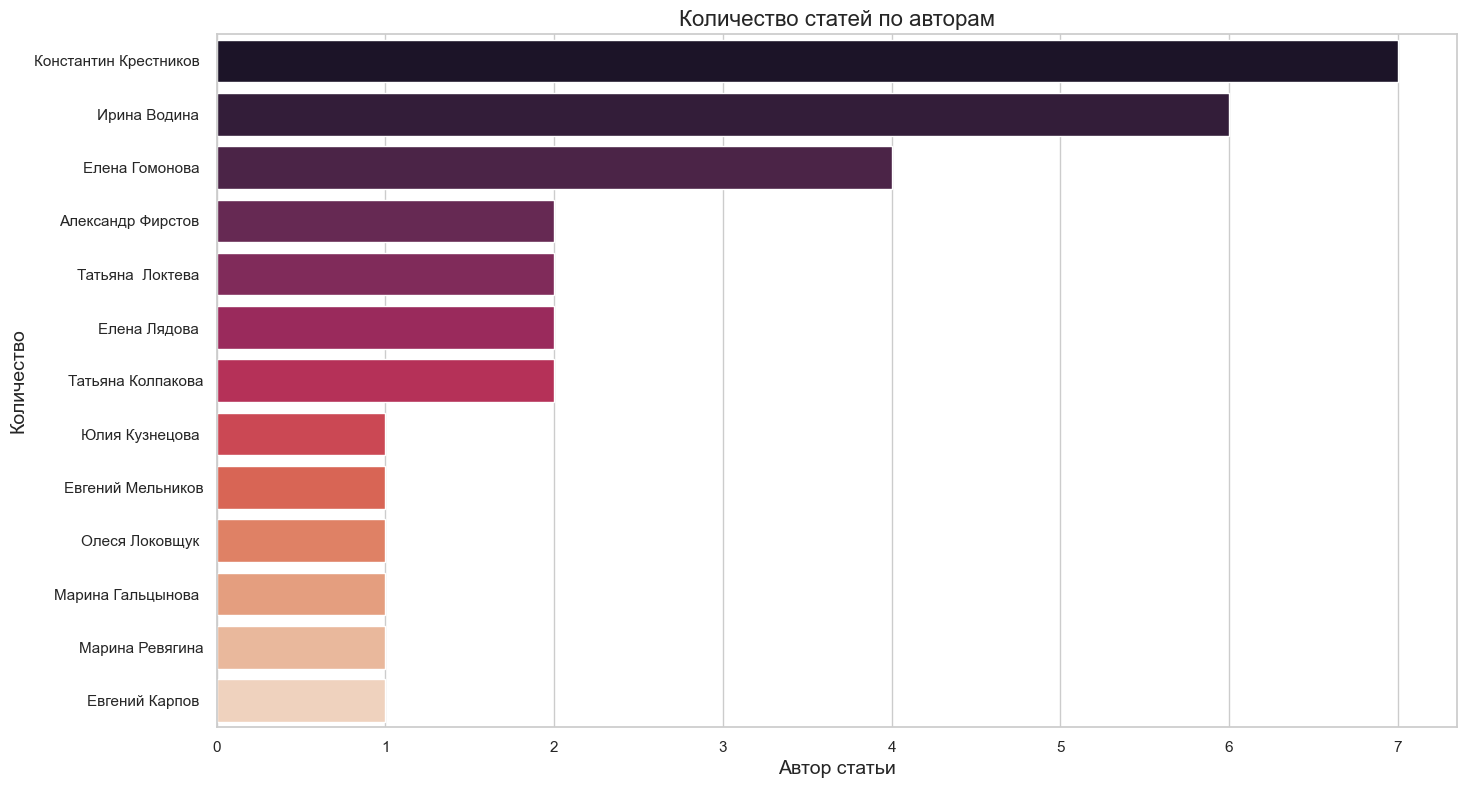

In [629]:
df['Автор статьи'].value_counts()
plt.figure(figsize=(16, 9))
sns.barplot(x = author_counts.values, y=author_counts.index, palette='rocket')
plt.xlabel('Автор статьи', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.title('Количество статей по авторам', fontsize=16);

In [630]:
df.to_excel('Итоговый датафрейм после обработки данных.xlsx')